<a href="https://colab.research.google.com/github/takashinnosuke/study_Keras/blob/main/Temperature_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#気象データセットのデータの調査
import os

data_dir = '/content/drive/MyDrive/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [15]:
#データの解析 NumPy配列に変換
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values =[float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

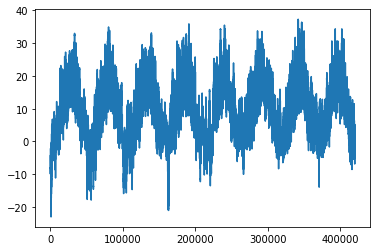

In [16]:
#気温の時系列データのプロット
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

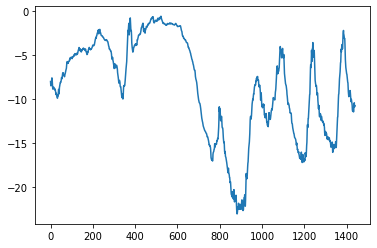

In [17]:
#最初の１０日間の気温データをプロット
plt.plot(range(1440), temp[:1440])
plt.show()

In [18]:
#データの正規化
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [27]:
#時系列サンプルとそれらの目的地を生成するジェネレータ
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)

    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [28]:
#訓練，検証，テストに使用するジェネレータの準備
lookback = 1440
step = 6
delay = 144
batch_size = 128

#訓練ジェネレータ
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0,
                      max_index=200000, shuffle=True, step=step, batch_size=batch_size)

#検証ジェネレータ
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001,
                    max_index=300000, step=step, batch_size=batch_size)

#テストジェネレータ
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001,
                    max_index=None, step=step, batch_size=batch_size)

#検証データセット全体を調べるためにval_genから抽出する時間刻みの数
val_steps = (300000 - 200001 - lookback) // batch_size

#テストデータセット全体を調べるためにtest_genから抽出する時間刻みの数
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [29]:
#常識的なベースラインのMAEを計算
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))

In [30]:
evaluate_naive_method()

0.2897359729905486


In [31]:
#平均絶対誤差を摂氏の誤差に変換
celsius_mae = 0.29 * std[1]

In [34]:
from keras.optimizer_v1 import Optimizer
#全結合モデルの訓練と評価
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


500/500 [==============================] - 18s 36ms/step - loss: 1.1413 - val_loss: 0.5954
Epoch 2/20
500/500 [==============================] - 17s 34ms/step - loss: 0.3735 - val_loss: 0.3433
Epoch 3/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2837 - val_loss: 0.3118
Epoch 4/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2627 - val_loss: 0.3380
Epoch 5/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2497 - val_loss: 0.3417
Epoch 6/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2432 - val_loss: 0.3115
Epoch 7/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2345 - val_loss: 0.3322
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2309 - val_loss: 0.3164
Epoch 9/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2248 - val_loss: 0.3127
Epoch 10/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2221 - val_los

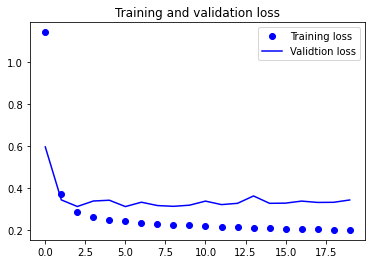

In [37]:
#結果をプロット
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.figure()

#損失値をプロット
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validtion loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
#GRUベースのモデルの訓練と評価
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20,
                              validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


500/500 [==============================] - 99s 193ms/step - loss: 0.4166 - val_loss: 0.3331
Epoch 2/20
500/500 [==============================] - 100s 199ms/step - loss: 0.3654 - val_loss: 0.3299
Epoch 3/20
500/500 [==============================] - 145s 290ms/step - loss: 0.3639 - val_loss: 0.3273
Epoch 4/20
500/500 [==============================] - 143s 285ms/step - loss: 0.3607 - val_loss: 0.3256
Epoch 5/20
500/500 [==============================] - 99s 198ms/step - loss: 0.3628 - val_loss: 0.3248
Epoch 6/20
500/500 [==============================] - 95s 191ms/step - loss: 0.3592 - val_loss: 0.3251
Epoch 7/20
500/500 [==============================] - 102s 204ms/step - loss: 0.3595 - val_loss: 0.3247
Epoch 8/20
500/500 [==============================] - 136s 272ms/step - loss: 0.3611 - val_loss: 0.3243
Epoch 9/20
500/500 [==============================] - 106s 211ms/step - loss: 0.3595 - val_loss: 0.3240
Epoch 10/20
500/500 [==============================] - 124s 248ms/step - loss:

In [39]:
#ドロップアウトで正則化したGRUベースのモデルの訓練と評価
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40,
                              validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


500/500 [==============================] - 164s 322ms/step - loss: 0.3213 - val_loss: 0.2771
Epoch 2/40
500/500 [==============================] - 162s 324ms/step - loss: 0.3064 - val_loss: 0.2750
Epoch 3/40
500/500 [==============================] - 161s 323ms/step - loss: 0.2980 - val_loss: 0.2707
Epoch 4/40
500/500 [==============================] - 161s 323ms/step - loss: 0.2948 - val_loss: 0.2696
Epoch 5/40
500/500 [==============================] - 161s 322ms/step - loss: 0.2889 - val_loss: 0.2726
Epoch 6/40
500/500 [==============================] - 161s 323ms/step - loss: 0.2847 - val_loss: 0.2731
Epoch 7/40
500/500 [==============================] - 161s 323ms/step - loss: 0.2815 - val_loss: 0.2740
Epoch 8/40
500/500 [==============================] - 161s 322ms/step - loss: 0.2730 - val_loss: 0.2790
Epoch 9/40
500/500 [==============================] - 162s 323ms/step - loss: 0.2709 - val_loss: 0.2780
Epoch 10/40
500/500 [==============================] - 161s 323ms/step - lo

In [ ]:
#ドロップアウトで正則化されたスタッキングGRUモデルの訓練と評価
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40,
                              validation_data=val_gen, validation_steps=val_steps)

In [ ]:
#逆向きのシーケンスを用いたLSTMでの訓練と評価
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

#特徴量として考慮する単語の数
max_features = 10000

# max_features個の最も祝言頻度の高い単語のうち，この数の単語を残してテキストをカット
max_len = 500

#データを読み込む
(x_train, y_train), (x_test, y_test) = \
  imdb.load_data(num_words=max_features)

#シーケンスを逆向きにする
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

#シーケンスをパディングする
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train)